## Imports

In [ ]:
# Import necessary packages here
import cv2
import numpy as np
from math import e, pow, pi
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from google.colab.patches import cv2_imshow
from PIL import Image
import PIL

# Part A: Hybrid Image (25 Points)

## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the “cutoff-frequency”. In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. [This](https://drive.google.com/uc?id=187FjBJLwnYXhylx08Vdh1SAA3AO-imYv) is the sample example.

NOTE: 

1. Reading [this](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) will help in understanding Part A.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.

We provided 7 pairs of aligned images. The alignment is important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

You are required to provide **THREE hybrid image results** and for ONE of your favorite result, please provide answers to the following **FOUR sub-parts** mentioned in the write-up.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

import cv2
img = cv2.imread('data/makeup_after.jpg')
img = img[1:, 1:, :]
print(img.shape)
cv2.imwrite('data/makeup_after.jpg', img)

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip

  0% 0.00/2.19M [00:00<?, ?B/s]
100% 2.19M/2.19M [00:00<00:00, 194MB/s]
Archive:  /content/hybrid_pyramid_input.zip
   creating: /content/data/
  inflating: /content/data/Afghan_girl_before.jpg  
  inflating: /content/data/motorcycle.bmp  
  inflating: /content/data/cat.bmp   
  inflating: /content/data/makeup_before.jpg  
  inflating: /content/data/fish.bmp  
  inflating: /content/data/bicycle.bmp  
  inflating: /content/data/makeup_after.jpg  
  inflating: /content/data/plane.bmp  
  inflating: /content/data/marilyn.bmp  
  inflating: /content/data/dog.bmp   
  inflating: /content/data/Afghan_girl_after.jpg  
  inflating: /content/data/submarine.bmp  
  inflating: /content/data/bird.bmp  
  inflating: /content/data/einstein.bmp  
(369, 249, 3)


True

## Code

In [ ]:
# Helper Functions

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  return output

def read_image(image_path):
  image = cv2.imread(image_path)
  return image

def gaussian_2D_filter(size, cutoff_frequency):
  center_i = size//2
  filter = np.zeros((size, size))
  factor = 1/(2*pi*pow(cutoff_frequency, 2))
  required_max = 20
  for i in range(size):
    for j in range(size):
      # calculate the pixel value based on the formula for Gaussian
      filter[i, j] = factor * pow(e, (-1 * ((pow(i-center_i, 2)+pow(j-center_i, 2)) / (2*pow(cutoff_frequency, 2)))))
  filter = filter / np.sum(filter)
  # For bigger filters, many values are going below zero.
  # So, for visualization purposes, multiply all the value by a constant
  filter_viz = filter / np.amax(filter)
  filter_viz = filter_viz * required_max
  return filter, filter_viz

def imgfilter(image, filter, channels=3):
  out = np.zeros_like(image)
  if channels==3:
    out[:, :, 0] = convolve2d(image[:, :, 0], filter, 'same')
    out[:, :, 1] = convolve2d(image[:, :, 1], filter, 'same')
    out[:, :, 2] = convolve2d(image[:, :, 2], filter, 'same')
  elif channels==1:
    out = convolve2d(image, filter, 'same')
  return out

def log_mag_FFT(image_1, image_2, low_frequencies, high_frequencies, hybrid_image):
  gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
  output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(gray))))
  for img in [image_2, low_frequencies, high_frequencies.astype(np.uint8), hybrid_image.astype(np.uint8)]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    output = np.hstack((output, np.log(np.abs(np.fft.fftshift(np.fft.fft2(gray))))))
  return output

Visualize the 2D Gaussian Kernal


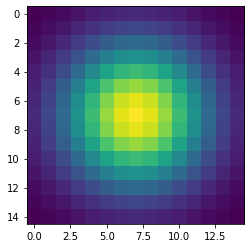

In [ ]:
visualize = False

for (image1, image2) in [('Afghan_girl_before.jpg', 'Afghan_girl_after.jpg'), ('motorcycle.bmp','bicycle.bmp'), ('bird.bmp','plane.bmp'), ('cat.bmp','dog.bmp'), ('marilyn.bmp','einstein.bmp'), ('makeup_after.jpg','makeup_before.jpg'), ('submarine.bmp','fish.bmp')]:
  image_path1 = 'data/'+image1
  image_path2 = 'data/'+image2
  image_1 = read_image(image_path1)
  image_2 = read_image(image_path2)

  if image1 == 'Afghan_girl_before.jpg':
    cutoff_frequency = 6
  elif image1 == 'motorcycle.bmp':
   cutoff_frequency = 5
  elif image1 == 'bird.bmp':
   cutoff_frequency = 4
  elif image1 == 'cat.bmp':
   cutoff_frequency = 6.5
  elif image1 == 'marilyn.bmp':
   cutoff_frequency = 3.5
  elif image1 == 'makeup_after.jpg':
   cutoff_frequency = 5.5
  elif image1 == 'submarine.bmp':
   cutoff_frequency = 3.5
  filter_size = cutoff_frequency*4+1
  if filter_size%1 == 0:
    filter_size = int(filter_size)
  """cutoff_frequency is the standard deviation, in pixels, of the 
  Gaussian blur that will remove the high frequencies from one image (image_1) and 
  remove the low frequencies from another image (image_2) (to do so, subtract a blurred
  version from the original version). You will want to tune this for every image pair to get the best results."""

  filter, filter_viz = gaussian_2D_filter(filter_size, cutoff_frequency)
  if image1 == 'marilyn.bmp':
    print('Visualize the 2D Gaussian Kernal')
    plt.imshow(filter_viz)

  """Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'.
  Remove the high frequencies from image_1 by blurring it. The amount of blur that works best will vary with different image pairs."""

  blurred_image1 = imgfilter(image_1, filter=filter)
  low_frequencies = blurred_image1

  # """Remove the low frequencies from image_2. The easiest way to do this is to
  # subtract a blurred version of image_2 from the original version of image_2.
  # This will give you an image centered at zero with negative values."""

  blurred_image2 = imgfilter(image_2, filter=filter)
  high_frequencies = image_2.astype(np.double) - blurred_image2.astype(np.double)

  # """Combine the high frequencies and low frequencies to obtain hybrid_image."""
  hybrid_image= high_frequencies + low_frequencies

# """Firstly, visualize low_frequencies, high_frequencies, and the hybrid image."""
  if visualize:
    if image1 == 'marilyn.bmp':
      cv2_imshow(low_frequencies)
      cv2_imshow(high_frequencies)
    cv2_imshow(hybrid_image)

  """Secondly, also visualize log magnitude of Fourier Transform of the above.
  HINT: You may use np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))) to achieve it."""

  FFT_image = log_mag_FFT(image_1, image_2, low_frequencies, high_frequencies, hybrid_image)
  if visualize:
    if image1 == 'marilyn.bmp':
      plt.figure()
      plt.imshow(FFT_image)


  # """Thirdly, visualize hybrid_image_scale using helper function vis_hybrid_image.
  # Lastly, save all your outputs."""
  if visualize:
    if image1 == 'marilyn.bmp':
      cv2_imshow(vis_hybrid_image(hybrid_image))

## **Write-up**


1.   Provide the original and filtered images.
2.   Provide the the hybrid image and hybrid_image_scale using given helper function *vis_hybrid_image*.
3.   Log magnitude of the Fourier transform of the two original images, the filtered images, and the hybrid image.
4.   Briefly explain how this works, using your favorite results as illustrations.

### The 3 hybrid images:
#### Note:
- The original images are also provided for reference (Order: Original img used for Low freq., Original img used for High freq., Hybrid img)

![AfghanGirl](https://drive.google.com/uc?export=view&id=1ocMANAdfNmBSky8q-Lj9lygFIkrbkxNr)
![](https://drive.google.com/uc?export=view&id=118wpTTywmnGp5Ne9NRyvtdHEspq9ToAb)
![](https://drive.google.com/uc?export=view&id=1_uqCr2hi2VxJK8iKhOXvjZAZngcf6ABQ)


### Detailed Write-up for one of the hybrid images:
#### 1) The 2 original & filtered images
- Einstein_original

  ![](https://drive.google.com/uc?export=view&id=1rjG0wRo92PtlsUvxTnIHRLMymRJOXNLx)

- Marilyn_original

  ![](https://drive.google.com/uc?export=view&id=1zU2VgCx7DTqqYTHW9nGx1fZPtH7EPuam)

- Marilyn_low_frequency

  ![](https://drive.google.com/uc?export=view&id=1Y2SomssIhRV3E9qa-Vii3eNZTDslbA9B)

- Einstein_high_frequency

  ![](https://drive.google.com/uc?export=view&id=1iHhGJXSiyuJsBro_xJA-Uo53VinVdwFf)

#### 2) hybrid image and hybrid_image_scale
- Hybrid Image

  ![](https://drive.google.com/uc?export=view&id=1rEjpy-ZuDTcpHDTVipdFFWkNHy7BzPHL)
- Hybrid_image_scale

  ![](https://drive.google.com/uc?export=view&id=1v_BrdJ6T2S0XBxfKkJKGMqK3Pnjg71aZ)

#### 3) Log magnitude of the Fourier transform of the two original images, filtered images, and hybrid image:
- Note: The below images are in the same order.
- ![](https://drive.google.com/uc?export=view&id=1HPYmGNzXILceAiqjeTSEcY05iZXAvqIe)

#### 4) Explanation:
- A Hybrid image is formed by adding a low-pass filtered version of an image & a high-pass filtered version of another image.
  ![](https://drive.google.com/uc?export=view&id=1k1H4GgA00k88wLflWzVXNx6ULLTjAG4h)
- The hybrid image when viewed from a close distance looks like the image used for high-pass filtering (See the biggest scale in the below scales of hybrid image). Since, from a close viewing distance, more details will be visible.
- Similarly, when the hybrid image is viewed from a farther disatnce, many details won't be visible (See the smallest scale in the below scales of hybrid image). Consequently, the hybrid image looks like the image used for low-pass filtering.
-   ![](https://drive.google.com/uc?export=view&id=1v_BrdJ6T2S0XBxfKkJKGMqK3Pnjg71aZ)
- <ins>Note:</ins> If the two (unfiltered) images involved have different amounts of details, selecting the one with more details for high-pass filtering & the one with lesser details for low-pass filtering might give better results.

# Part B: Pyramid Image (25 Points)

## Overview
Choose an image that has interesting variety of textures (from Flickr or your own images). The images should be atleast 640X480 pixels and converted to grayscale. Write code for a Gaussian and Laplacian pyramid of level N (use for loops). In each level, the resolution should be reduced by a factor of 2. Show the pyramids for your chosen image in your write-up. Here is an [example](https://drive.google.com/uc?id=17Y287EA-GJ2z0wtm_M7StIWsXyFeHvrz).

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# # Download Data -- run this cell only one time per runtime
# !gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
# !unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip

  0% 0.00/2.19M [00:00<?, ?B/s]
100% 2.19M/2.19M [00:00<00:00, 149MB/s]
Archive:  /content/hybrid_pyramid_input.zip
replace /content/data/Afghan_girl_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!gdown 11Ikv79W2dexJ9jBzLdla_2BpOql9sf_G
!ls

Downloading...
From: https://drive.google.com/uc?id=11Ikv79W2dexJ9jBzLdla_2BpOql9sf_G
To: /content/cybertronic_bison.webp

  0% 0.00/1.35M [00:00<?, ?B/s]
100% 1.35M/1.35M [00:00<00:00, 138MB/s]
cybertronic_bison.webp	data  hybrid_pyramid_input.zip	sample_data


## Code

In [ ]:
# Populate Helper Functions:
def scale_down(Smooth_image):
  height, width = Smooth_image.shape
  image = Image.fromarray(np.uint8(Smooth_image))
  image = image.resize((int(width/2), int(height/2)), resample=PIL.Image.NEAREST)
  return np.array(image)

def scale_up(image):
  height, width = image.shape
  image = cv2.resize(image, (int(width*2), int(height*2)), interpolation = cv2.INTER_NEAREST)
  return image

def construct_GaussianPyramid(image, num_levels):
  image = np.array(image)
  G = [image]
  for level in range(num_levels):
    smooth_image = imgfilter(image, smoothing_filter, 1)
    image = scale_down(smooth_image)
    G.append(image)
  return G

def construct_LaplacianPyramid(G, num_levels):
  L = [G[-1]]  
  for i in range(len(G)-1, 0, -1):
    scaled_up_img = scale_up(G[i])
    smoothed_img = imgfilter(scaled_up_img, smoothing_filter, 1)
    l = G[i-1] - smoothed_img
    L.append(l)
  return L
  

def pyramidsGL(image, num_levels):
  ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im. 
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively. '''
  G = construct_GaussianPyramid(image, num_levels)
  Gp = G[0]
  factor = 2
  for g in G[1:]:
    Gp = np.hstack((Gp, cv2.resize(g, None, fx=factor, fy=factor)))
    factor *= 2
  L = construct_LaplacianPyramid(G, num_levels)
  Lp = L[-1]
  factor = 2
  for l in L[::-1][1:]:
    Lp = np.hstack((Lp, cv2.resize(l, None, fx=factor, fy=factor)))
    factor *= 2
  return Gp, Lp, G, L

def displayPyramids(pyr):
  '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.'''
  output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(pyr[:, :img_size]))))
  output = (output - np.amin(output)) / (np.amax(output)-np.amin(output))
  for i in range(1, num_levels+1):
    curr_FFT = np.log(np.abs(np.fft.fftshift(np.fft.fft2(pyr[:, img_size*i:img_size*(i+1)]))))
    curr_FFT = (curr_FFT - np.amin(curr_FFT)) / (np.amax(curr_FFT)-np.amin(curr_FFT))
    output = np.hstack((output, curr_FFT))
  cv2_imshow(pyr)
  f = plt.figure()
  f.set_figwidth(25)
  f.set_figheight(5)
  plt.imshow(output)
  return

def reconstructLaplacianPyramid(L):
  '''Given a Laplacian Pyramid L, reconstruct an image img.'''
  prev_recon = L[0]
  for i in range(1, num_levels+1):
    recon = L[i] + imgfilter(scale_up(prev_recon), smoothing_filter, 1)
    prev_recon = recon
  return recon

def compute_L2(img, reconstruction):
  diff = img - reconstruction
  diff_sq = np.square(diff)
  return np.sum(diff_sq)

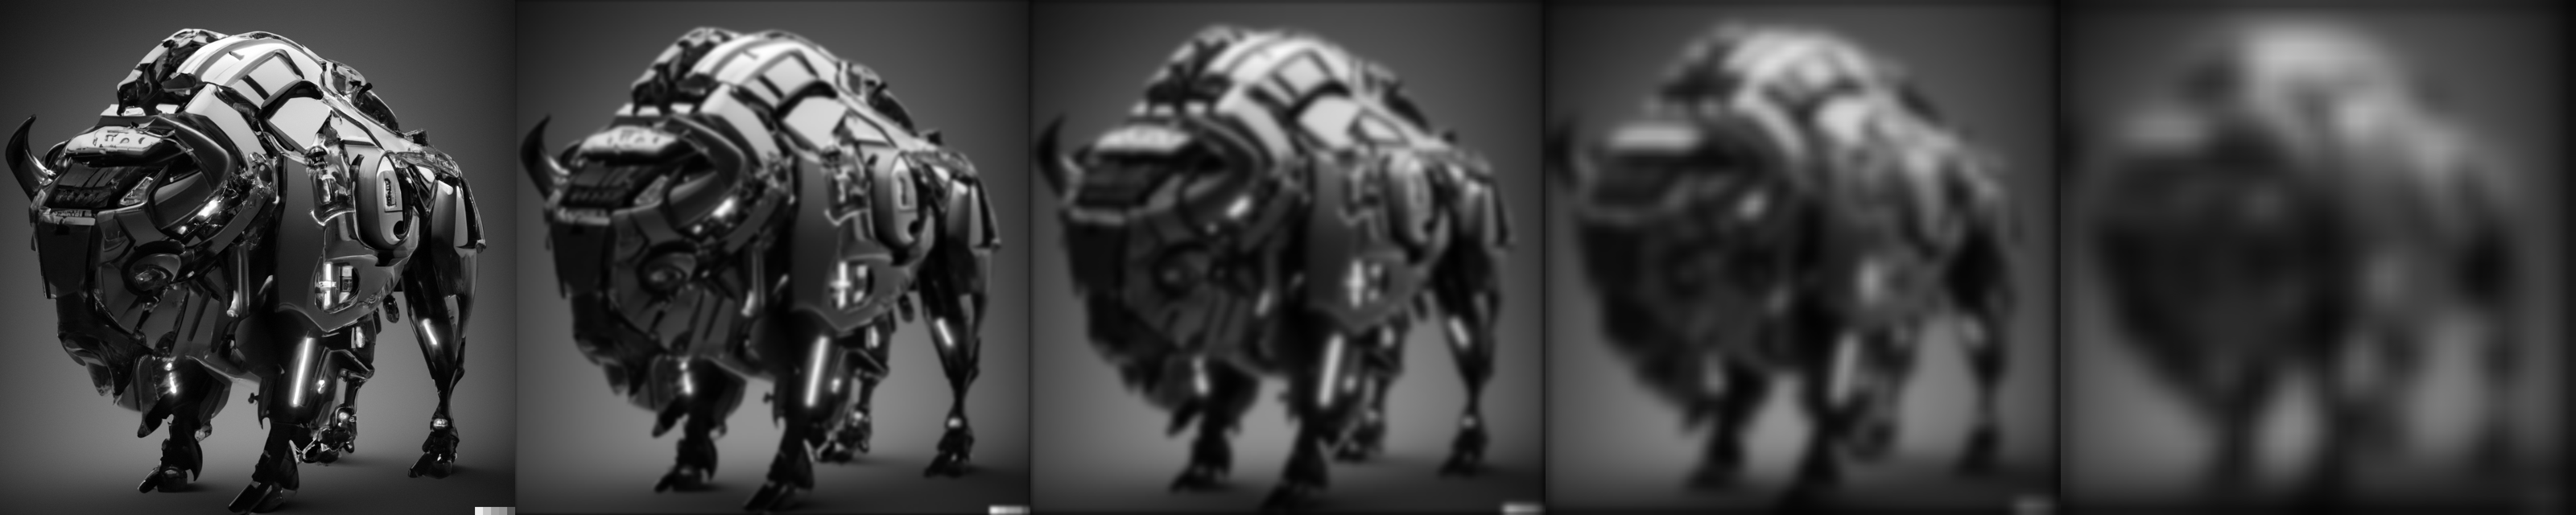

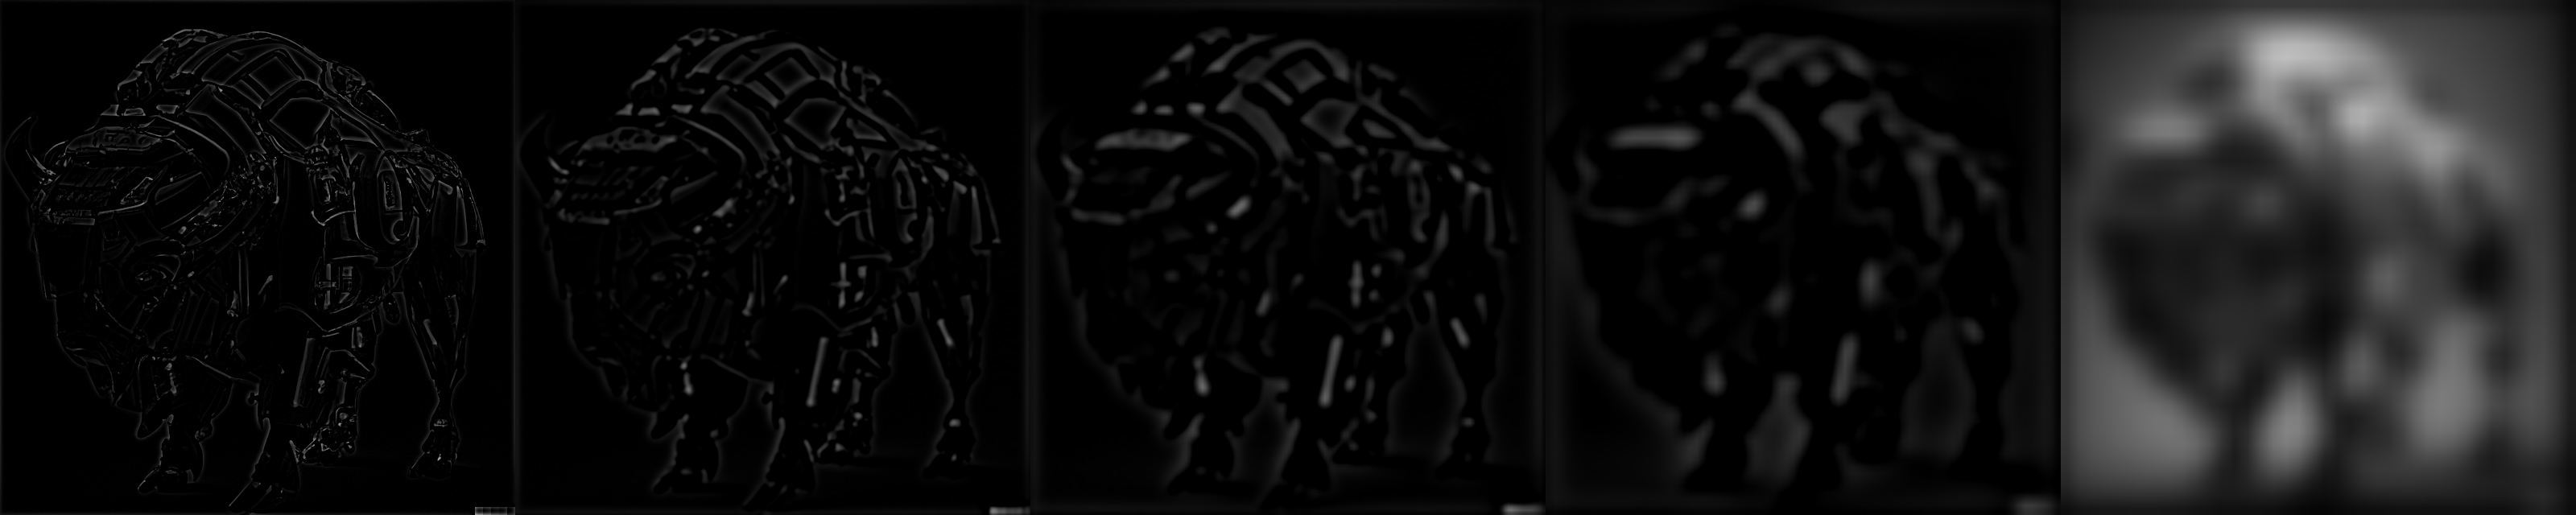



*************** Reconstruction Error =  0.0  ***************




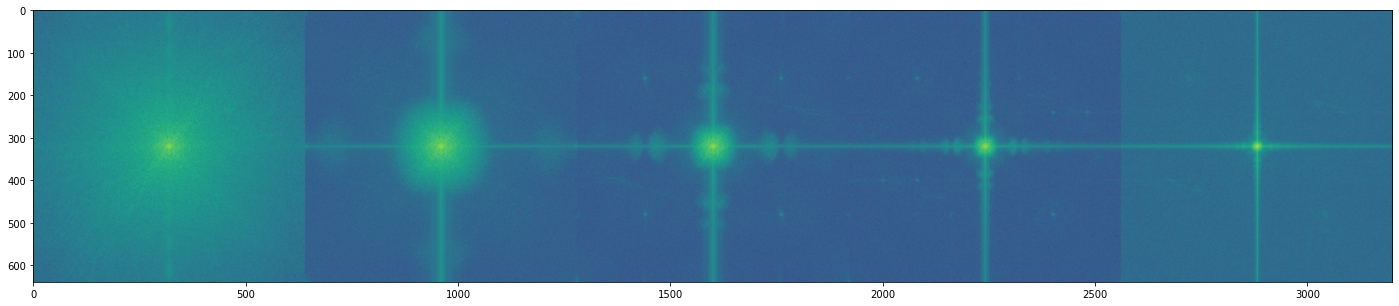

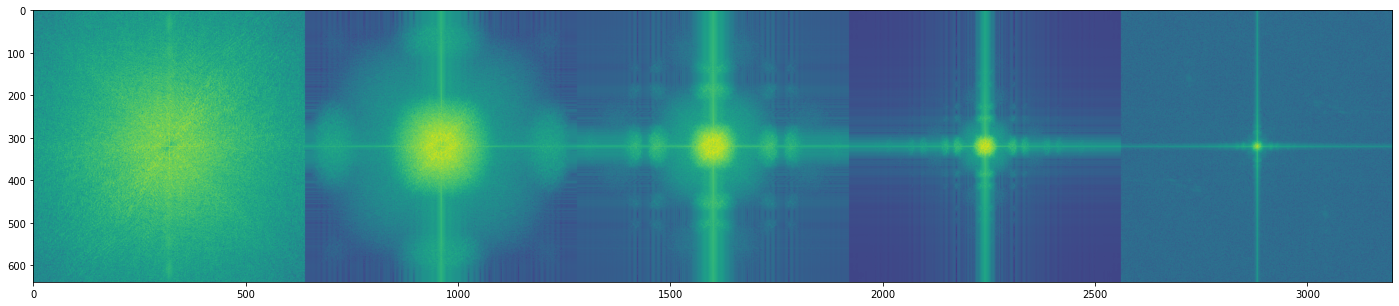

In [ ]:
""" 
Steps: 
1. Load an image im.
2. Call function pyramidsGL with image and num_levels = 5
3. Call function displayPyramids with G, L
4. Call function reconstructLaplacianPyramid with the generated L
5. Compute reconstruction error with L2 norm and print the error value.
"""

image_path = 'cybertronic_bison.webp'
img = Image.open(image_path).convert('L')
img_size = 640
img = img.resize((img_size, img_size))
smooth_cutoff_frequency = 2
smooth_filter_size = 4*smooth_cutoff_frequency + 1
smoothing_filter, _ = gaussian_2D_filter(smooth_filter_size, smooth_cutoff_frequency)
img = np.array(img)
num_levels = 4
Gp, Lp, G, L = pyramidsGL(img, num_levels)
pyrs = np.vstack((Gp, Lp))
displayPyramids(Gp)
displayPyramids(Lp)
reconstruction = reconstructLaplacianPyramid(L)
reconstruction_error = compute_L2(img, reconstruction)
print('\n\n*************** Reconstruction Error = ', reconstruction_error, ' ***************\n\n')

## **Write-up**

1. (10 Points) Display a Gaussian and Laplacian pyramid of level 5 (using your code). It should be formatted similar to [this](https://drive.google.com/file/d/1mAommQeJsp7WS8QCrZRcr8cQiltPPOh2/view?usp=sharing) figure.

2. (10 Points) Display the FFT amplitudes of your Gaussian/Laplacian pyramids Appropriate display ranges (from 0 to 1) should be chosen so that the changes in frequency in different levels of the pyramid are clearly visible. Explain  what the Laplacian and Gaussian pyramids are doing in terms of frequency. [This](https://drive.google.com/file/d/1BqTPKq6Mqqxl5jNNPkvx4JOA5MRgVq08/view?usp=sharing) looks like the expected output.

3. (5 Points) Image Reconstruction


### The following image is used for this part of the assignment:
![cybertronic_bull](https://drive.google.com/uc?export=view&id=19W58O6LjrBo3BbhCbRUd2oaCz-4yRDx_)
### 1) Gaussian & Laplacian pyramids
![Gaussian_laplacian_pyramids](https://drive.google.com/uc?export=view&id=1AqpVv5077DQNsHnxSXovY9Vph8OEA-xh)
### 2) FFT amplitudes of Gaussian & Laplacian pyramids
![FFTs_Gaussian_pyramids](https://drive.google.com/uc?export=view&id=1Dqvx_LzTD_yh8J4-2zlmsPbSc4c-_Rtd)
![FFTs_Laplacian_pyramids](https://drive.google.com/uc?export=view&id=1yr57nITNIk3DK-25J1ugp52_FHsv8NfY)
- As the Gaussian pyramid progress towards smaller resolutions, the high frequency components get discarded & only low frequency components get preserved. Consequently, this prevents aliasing while scaling down.
- The Laplacian pyramid captures the lost frequencies at each level in the Gaussian pyramid. Since all the frequencies are captured, a reconstruction using the Laplacian pyramid will be lossless.

### 3) Image Reconstruction from Laplacian pyramid
![Laplacian_pyramid_reconstruction](https://drive.google.com/uc?export=view&id=1yhxghJEOzx5qPPhPYfs_KzrCPC8v3GI-)
- As expected, a reconstruction error of 0 is obtained.

# Part C: Edge detection (25 points)

## Overview
The main steps of edge detection are: (1) assign a score to each pixel; (2) find local maxima along the direction perpendicular to the edge. Sometimes a third step is performed where local evidence is propagated so that long contours are more confident or strong edges boost the confidence of nearby weak edges. Optionally, a thresholding step can then convert from soft boundaries to hard binary boundaries. Here are sample outputs.

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1orUji5-1CzjWmHk0g5y5kOVFhshNfhN8" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1npyMjhlRAeP1GaukV38SOlCe-O0whX37" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="https://drive.google.com/uc?id=1TX54zNTG6q5ajitwV024FS-nOJiVP2VN" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1dPPSFDmakh8DQwlpTYmNXJPNHapdZF8S" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

**Hint:** Reading these papers will help understanding and may help with the programming assignment.

[The design and use of steerable filters](http://people.csail.mit.edu/billf/papers/steerpaper91FreemanAdelson.pdf)

[Berkeley Pb Detector](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/papers/mfm-pami-boundary.pdf)

[Multi-scale edge detection](https://home.ttic.edu/~xren/publication/xren_eccv08_multipb.pdf)

## Data
We have provided 50 test images and the codes associated to download the unzip the data. Your job is to build a simple gradient-based edge detector and to extend it using multiple oriented filters.

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
!unzip "/content/edge_detection_inputs.zip" -d "/content/"

In [ ]:
# Import necessary packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow ## Use this to show image in colab

img_path = "/content/edge_detection_inputs/3096.jpg" ## add the path here
img = cv2.imread(img_path)

## Subpart 1: Simple edge detection (8 points)
Build a simple gradient-based edge detector that includes the following functions
```
def gradientMagnitude(im, signma)
```
This function should take an RGB image as input, smooth the image with Gaussian std=sigma, compute the x and y gradient values of the smoothed image, and output image maps of the gradient magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x and y gradients. mag and theta should be the same size as im.

```
def edgeGradient(im):
```
This function should use gradientMagnitude to compute a soft boundary map and then perform non-maxima suppression. For this assignment, it is acceptable to perform non-maxima suppression by retaining only the magnitudes along the binary edges produce by the Canny edge detector: `cv2.Canny(im)`. 

If desired, the boundary scores can be rescaled, e.g., by raising to an exponent: `mag2 = mag.^0.7` , which is primarily useful for visualization. 


Gradient Magnitude, Output of edgeGradient & Gradient orientation are shown below:



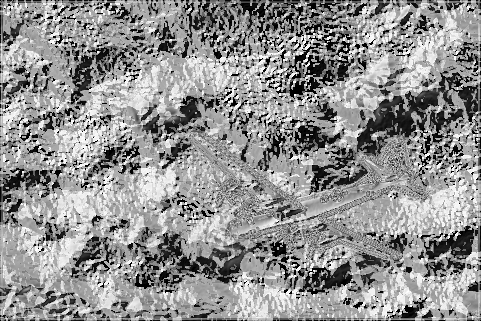

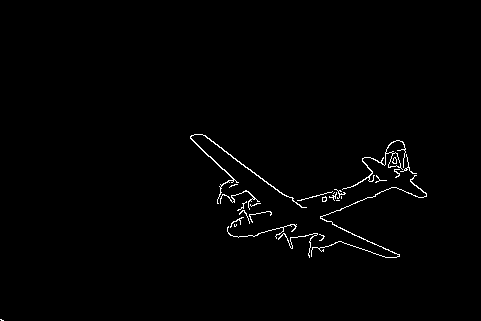

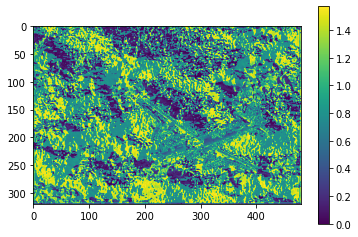

In [ ]:
from numpy.linalg import norm

def compute_grad_mags(grads_bgr_x, grads_bgr_y=None, display=False):
  grad_mag_x = np.expand_dims(norm(grads_bgr_x, axis=2), axis=2)
  grad_mag_y = np.expand_dims(norm(grads_bgr_y, axis=2), axis=2)
  grad_mags_xy = np.concatenate((grad_mag_x, grad_mag_y), axis=2)
  grad_mags = norm(grad_mags_xy, axis=2)
  grad_mags = ((grad_mags-np.amin(grad_mags))/(np.amax(grad_mags)-np.amin(grad_mags))) * 255
  if display==True:
    cv2_imshow(grad_mags)
  return grad_mags

def compute_grad_orientations(grads_bgr_x, grads_bgr_y, display=False):
  rows = grads_bgr_y.shape[0]
  cols = grads_bgr_y.shape[1]
  grads_b = np.expand_dims(norm(np.concatenate((np.expand_dims(grads_bgr_x[:, :, 0], axis=2), np.expand_dims(grads_bgr_y[:, :, 0], axis=2)), axis=2), axis=2), axis=2)
  grads_g = np.expand_dims(norm(np.concatenate((np.expand_dims(grads_bgr_x[:, :, 1], axis=2), np.expand_dims(grads_bgr_y[:, :, 1], axis=2)), axis=2), axis=2), axis=2)
  grads_r = np.expand_dims(norm(np.concatenate((np.expand_dims(grads_bgr_x[:, :, 2], axis=2), np.expand_dims(grads_bgr_y[:, :, 2], axis=2)), axis=2), axis=2), axis=2)
  grads = np.concatenate((grads_b, grads_g, grads_r), axis=2)
  grad_y_orientation = np.zeros((rows, cols))
  grad_x_orientation = np.zeros((rows, cols))
  max_channel = np.argmax(grads, axis=2)
  for i in range(grads.shape[0]):
    for j in range(grads.shape[1]):
      idx = max_channel[i, j]
      grad_x_orientation[i, j] = grads_bgr_x[i, j, idx]
      grad_y_orientation[i, j] = grads_bgr_y[i, j, idx]
  grad_orientation = np.arctan2(grad_y_orientation, grad_x_orientation)
  if display:
    plt.imshow(grad_orientation)
    plt.colorbar()

def gradientMagnitude(im, sigma=None, filter=None, display=False):
  '''
  im: input image
  sigma: standard deviation value to smooth the image

  outputs: gradient magnitude and gradient direction of the image
  '''
  if filter==None:
    cutoff_frequency = sigma
    filter_size = cutoff_frequency*4+1
    filter, _ = gaussian_2D_filter(filter_size, cutoff_frequency)
  bgr_blur = imgfilter(im, filter=filter)
  grads_bgr_x = np.zeros_like(bgr_blur)
  grads_bgr_y = np.zeros_like(bgr_blur)
  ddepth = cv2.CV_16S
  grads_bgr_x[:, :, 0] = cv2.Scharr(bgr_blur[:, :, 0], ddepth, 1, 0)
  grads_bgr_x[:, :, 1] = cv2.Scharr(bgr_blur[:, :, 1], ddepth, 1, 0)
  grads_bgr_x[:, :, 2] = cv2.Scharr(bgr_blur[:, :, 2], ddepth, 1, 0)
  grads_bgr_y[:, :, 0] = cv2.Scharr(bgr_blur[:, :, 0], ddepth, 0, 1)
  grads_bgr_y[:, :, 1] = cv2.Scharr(bgr_blur[:, :, 1], ddepth, 0, 1)
  grads_bgr_y[:, :, 2] = cv2.Scharr(bgr_blur[:, :, 2], ddepth, 0, 1)
  grad_mags = compute_grad_mags(grads_bgr_x, grads_bgr_y, display=display)
  grad_orientation = compute_grad_orientations(grads_bgr_x, grads_bgr_y, display=display)
  return grad_mags, grad_orientation

def edgeGradient(im):
  '''
  im: input image

  output: a soft boundary map of the image
  '''
  edges = cv2.Canny(im, 100, 200, L2gradient=True)
  cv2_imshow(edges)

print('Gradient Magnitude, Output of edgeGradient & Gradient orientation are shown below:\n')
sigma = 1
grad_magnitude, grad_orientation = gradientMagnitude(img, sigma=sigma, display=True)
edgeGradient(img)

## Subpart 2: Improved Edge Detection (8 points)
Try to improve your results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions:
```
def orientedFilterMagnitude(im):
```
Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated Gaussian derivative filters. Explain your choice of filters in the write-up. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.
```
def edgeOrientedFilters(im):
```
Similar to Subpart 1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

In [ ]:
np.linspace(3.5, 7.5, 9)

array([3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5])

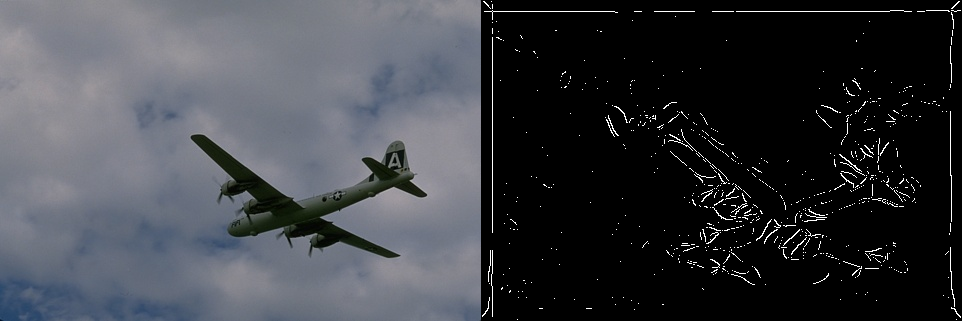

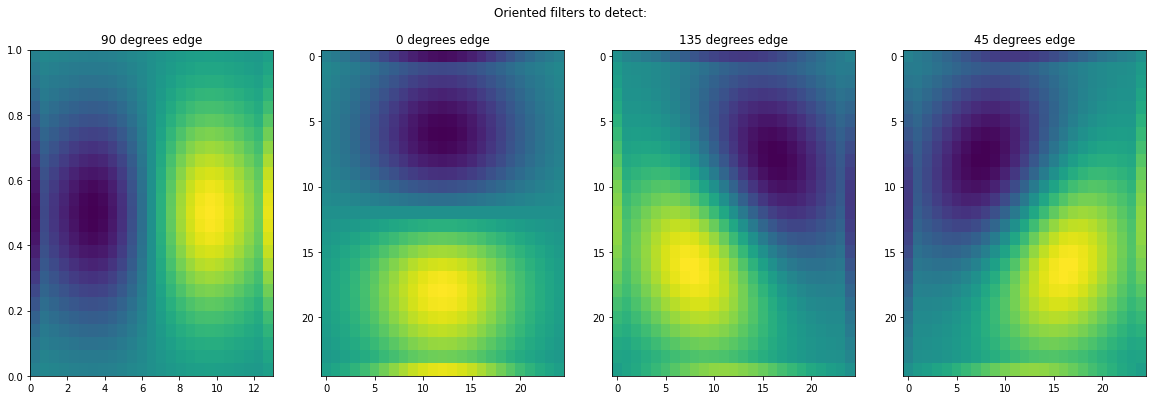

In [ ]:
def orientedFilterMagnitude(im, sigma, display=False):
  '''
  im: input image
  outputs: gradient magnitude and gradient direction of the image
  '''
  rows = im.shape[0]
  cols = im.shape[1]
  cutoff_frequency = sigma
  filter_size = int(cutoff_frequency*4+1)
  filter, _ = gaussian_2D_filter(filter_size, cutoff_frequency)
  # bgr_blur = imgfilter(im, filter=filter)
  x_derivative_kernal = np.array([[-1,0,1]])
  filter_x = convolve2d(filter, x_derivative_kernal, 'same')
  y_derivative_kernal = np.array([[-1],[0],[1]])
  filter_y = convolve2d(filter, y_derivative_kernal, 'same')
  derivative_45_kernal = np.array([[0,0,-1], [0,0,0], [1,0,0]])
  filter_45 = convolve2d(filter, derivative_45_kernal, 'same')
  derivative_135_kernal = np.array([[-1,0,0], [0,0,0], [0,0,1]])
  filter_135 = convolve2d(filter, derivative_135_kernal, 'same')
  if display:
    fig, axs = plt.subplots(1, 4, figsize=(20,6))
    fig.suptitle('Oriented filters to detect:')
    axs[0].imshow(filter_x, extent=[0,13,0,1], aspect='auto')
    axs[0].set_title('90 degrees edge')
    axs[1].imshow(filter_y, aspect='auto')
    axs[1].set_title('0 degrees edge')
    axs[2].imshow(filter_45, aspect='auto')
    axs[2].set_title('135 degrees edge')
    axs[3].imshow(filter_135, aspect='auto')
    axs[3].set_title('45 degrees edge')

  bgr_x = imgfilter(im, filter=filter_x)
  bgr_y = imgfilter(im, filter=filter_y)
  bgr_45 = imgfilter(im, filter=filter_45)
  bgr_135 = imgfilter(im, filter=filter_135)
  grad_mag_x = norm(bgr_x, axis=2)
  grad_mag_y = norm(bgr_y, axis=2)
  grad_mag_45 = norm(bgr_45, axis=2)
  grad_mag_135 = norm(bgr_135, axis=2)
  grad_mag = np.maximum(np.maximum(np.maximum(grad_mag_x, grad_mag_y), grad_mag_45), grad_mag_135)
  grad_orientations = np.stack([grad_mag_x, grad_mag_45, grad_mag_y, grad_mag_135], axis=2)
  grad_orientations = np.argmax(grad_orientations, axis=2) * pi/4
  return grad_mag, grad_orientations
  


def edgeOrientedFilters(im):
  '''
  im: input image

  output: a soft boundary map of the image
  '''
  # Reference Used: https://theailearner.com/tag/non-max-suppression/
  for img in ['3096']:#'3096','42049','102061','45096','54082','62096','89072','19021','101085']:
    img = img.strip()
    im = cv2.imread('/content/edge_detection_inputs/'+img+'.jpg')
    stack = im 
    cols = im.shape[1]
    if 1:
      sigma = 6
      grad_mag, grad_orientations = orientedFilterMagnitude(im, sigma, True)
      final_edges = np.zeros_like(grad_orientations)
      for i in range(1, grad_mag.shape[0]-1):
        for j in range(1, grad_mag.shape[1]-1):
          if grad_orientations[i,j] == 0:
            if (grad_mag[i,j]>grad_mag[i,j-1]) and (grad_mag[i,j]>grad_mag[i,j+1]):
              final_edges[i,j] = 255
          elif grad_orientations[i,j] == pi/4:
            if (grad_mag[i,j]>grad_mag[i+1,j-1]) and (grad_mag[i,j]>grad_mag[i-1,j+1]):
              final_edges[i,j] = 255
          elif grad_orientations[i,j] == 2*pi/4:
            if (grad_mag[i,j]>grad_mag[i-1,j]) and (grad_mag[i,j]>grad_mag[i+1,j]):
              final_edges[i,j] = 255
          elif grad_orientations[i,j] == 3*pi/4:
            if (grad_mag[i,j]>grad_mag[i-1,j-1]) and (grad_mag[i,j]>grad_mag[i+1,j+1]):
              final_edges[i,j] = 255
          else:
            print("Multiplication didn't happen properly!")
      stack = np.hstack((stack, cv2.cvtColor(np.uint8(final_edges), cv2.COLOR_GRAY2RGB)))
    cv2_imshow(stack)


  
# possibly try with different filter sizes
edgeOrientedFilters(img)


## Write-up (9 points)

1.   **(2 points)** Description of any design choices and parameters
2.   **(1 points)** The bank of filters used for Subpart 2 ([plt.imshow with extent](https://stackoverflow.com/questions/13384653/imshow-extent-and-aspect/13390798#13390798) or [cv2.normalize to convert output into grayscale](https://stackoverflow.com/questions/39808545/implement-mat2gray-in-opencv-with-python) may help with visualization)
3.   **(5 points)** Qualitative results: choose five example images; show input images and outputs of each edge detector
4.   **(1 points)** Discuss the quality of your outputs and state one possible way for improvement. Improvements could provide, for example, a better boundary pixel score or a better suppression technique. Your idea could come from a paper you read, but cite any sources of ideas.



#### 1) Design choices & Parameters:
- In the 1st sub-part, a Scharr kernal is used to compute the gradients as it is known to produce more accurate boundaries than the Sobel filter.
- To generate oriented Derivative of Gaussian filters in the 2nd sub-part, the Gaussian kernal is convolved with various oriented derivative filters (instead of convolving the Gaussian with a X-derivative filter & rotating the reultant).
- The std dev of the smoothing gaussian filter is tuned separately for all the images shown below.

#### 2) Filter bank (for std dev = 5):
![Filter bank](https://drive.google.com/uc?export=view&id=1qytL3UZVIkB2Lf4HBv6xJBF52Sl5v0to)

#### 3) Edge Detection results:
- ![edges_1](https://drive.google.com/uc?export=view&id=1Ry1ACwRrE35oPtwxFM5c3kx5b_rPrT3H)
- ![edges_2](https://drive.google.com/uc?export=view&id=1Ru32KraRbz9omdoSxToCRZrN1Pf2nyId)
- ![edges_3](https://drive.google.com/uc?export=view&id=1jWpFh7VABhpXllP3zMCtCD8MvmGXC128)
- ![edges_4](https://drive.google.com/uc?export=view&id=1KKMHdH_gvh9lUlrxFoTaGm1PeU2vnWy2)
- ![edges_5](https://drive.google.com/uc?export=view&id=1Q7f0wYpBjKHHkL4Nt78EcBiQYhqzpLR6)

#### 4) Quality of outputs & scope of Improvements:
- Since the used oriented filters detect edges in the directions of 0, 45, 90 & 135 degrees, spoked wheels (with spokes along these 4 directions & directions which are 180 degrees from these 4 diections) can be seen in the results at some instances.
- The above implementation used a filter bank with only 4 filters. Using a bigger filter bank can help the results a little.
- Histeresis thresholding (as done in the Canny algorithm) can suppress a few spurious edges.

# Part D: Template Matching (25 points) 

## Overview
The goal of this part is to build a template maching algorithm for where's waldo puzzle. 
The end product should be finding waldo in puzzle images. 


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
!unzip "/content/Part4_data.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
To: /content/Part4_data.zip

  0% 0.00/2.04M [00:00<?, ?B/s]
100% 2.04M/2.04M [00:00<00:00, 159MB/s]
Archive:  /content/Part4_data.zip
   creating: /content/Part4_data/
  inflating: /content/__MACOSX/._Part4_data  
  inflating: /content/Part4_data/.DS_Store  
  inflating: /content/__MACOSX/Part4_data/._.DS_Store  
   creating: /content/Part4_data/puzzle2/
  inflating: /content/__MACOSX/Part4_data/._puzzle2  
   creating: /content/Part4_data/puzzle1/
  inflating: /content/__MACOSX/Part4_data/._puzzle1  
  inflating: /content/Part4_data/puzzle2/waldo.png  
  inflating: /content/__MACOSX/Part4_data/puzzle2/._waldo.png  
  inflating: /content/Part4_data/puzzle2/map.jpg  
  inflating: /content/__MACOSX/Part4_data/puzzle2/._map.jpg  
  inflating: /content/Part4_data/puzzle1/waldo.jpg  
  inflating: /content/__MACOSX/Part4_data/puzzle1/._waldo.jpg  
  inflating: /content/Part4_data/puzzle1/pic1.jpeg  
  infl

## Code

We provide the following functions for plotting your results 


In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

It is always advised for you to visualize and get familar with waldo and puzzle image. 

Visualize both the waldo and puzzle images.

(1902, 3000, 3) (61, 43, 3)
(720, 1280, 3) (26, 24, 3)


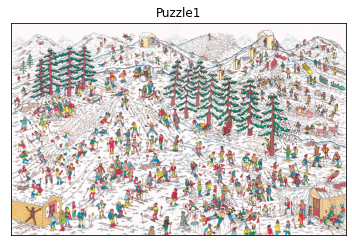

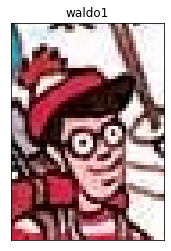

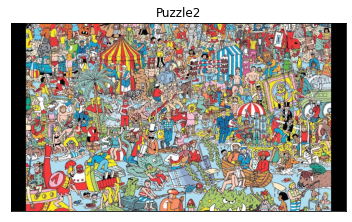

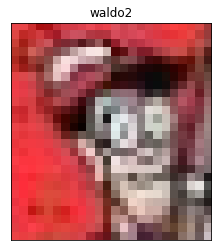

In [ ]:
puzzle1 = cv2.imread('Part4_data/puzzle1/pic1.jpeg')
waldo1 = cv2.imread('Part4_data/puzzle1/waldo.jpg')
print(puzzle1.shape, waldo1.shape)
plot_image(puzzle1, 'Puzzle1')
plot_image(waldo1, 'waldo1')

puzzle2 = cv2.imread('Part4_data/puzzle2/map.jpg')
waldo2 = cv2.imread('Part4_data/puzzle2/waldo.png') 
print(puzzle2.shape, waldo2.shape)
plot_image(puzzle2, 'Puzzle2')
plot_image(waldo2, 'waldo2')

### Subpart 1: Template Matching with OpenCV
OpenCV provide Template Matching functions below link. 

https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

You can use this function for implementing simple where's waldo algorithm.

This part helps you to understand the concepts of Template Matching and OpenCV Library. This is just for reference.

(673, 512) (2544, 1341)


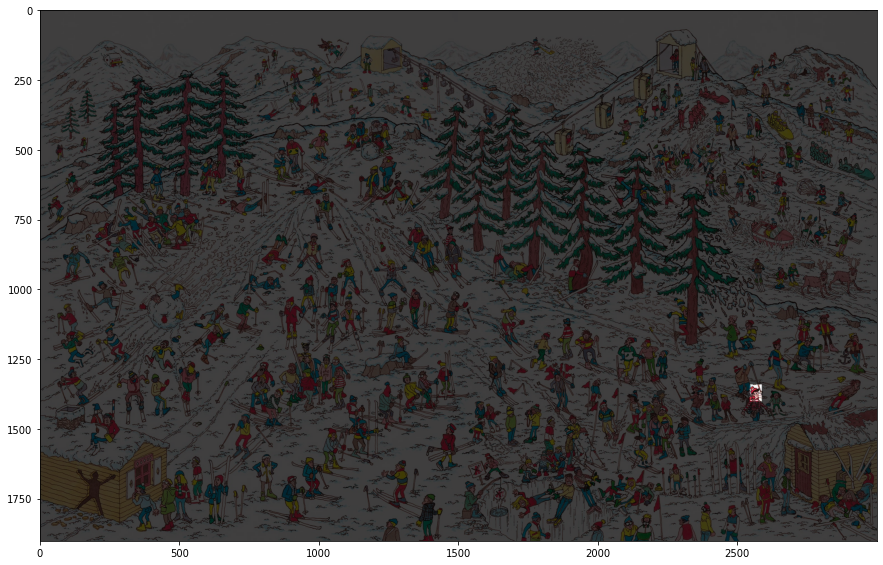

In [ ]:
import copy 
waldo = copy.copy(waldo1)
map = copy.copy(puzzle1)

(waldoHeight, waldoWidth) = waldo.shape[:2]

result = cv2.matchTemplate(map, waldo, cv2.TM_CCOEFF)
(_, _, minLoc, maxLoc) = cv2.minMaxLoc(result)
print(minLoc, maxLoc)

# grab the bounding box of waldo and extract him from the puzzle image
topLeft = maxLoc
botRight = (topLeft[0] + waldoWidth, topLeft[1] + waldoHeight)
roi = map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]]

# construct a darkened transparent 'layer' to darken everything
# in the map except for Waldo
mask = np.zeros(map.shape, dtype = "uint8")
map = cv2.addWeighted(map, 0.25, mask, 0.75, 0)

map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]] = roi

# display the images
result_rgb = cv2.cvtColor(map, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (15, 15))
plt.imshow(result_rgb)

### Subpart 2: Template Matching from Scratch

Implement the Sum of Squared Distance (SSD) template matching algorithm from scratch (Don't use cv2.matchTemplate).

Then, show the results of where's waldo for two puzzle images.

Hints: You can borrow the codes from Part1 and Part2. Please read methods for matching with filters in Lecture Slide.  

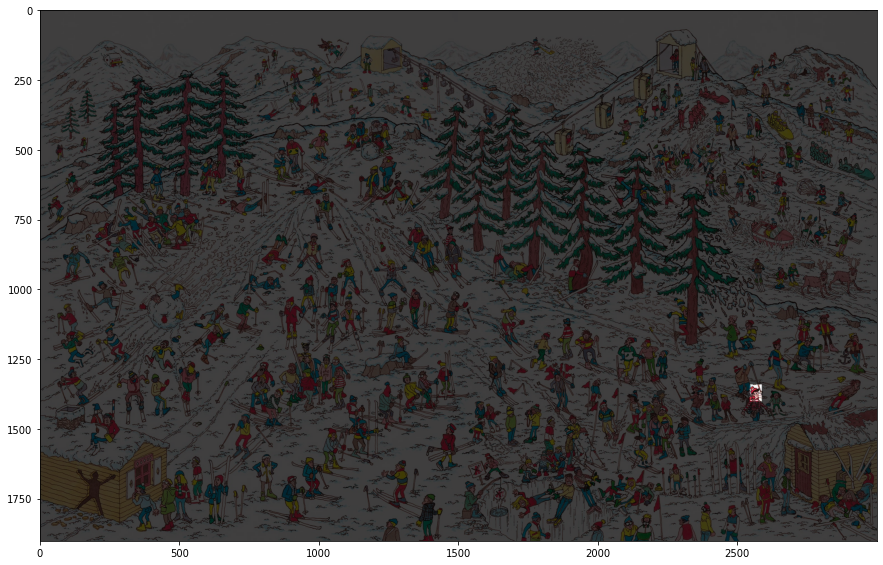

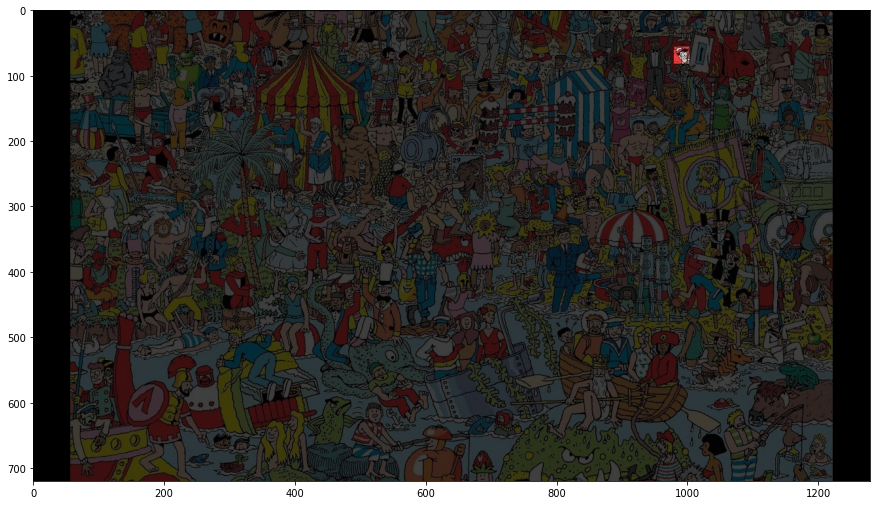

In [ ]:
def ssd(img_patch, template):
  assert img_patch.shape ==  template.shape, str(img_patch.shape)+str(template.shape)
  diff = img_patch - template
  sq_diff = np.square(diff)
  return np.sum(sq_diff)

def find_waldo(puzzle, waldo):
  (puzzle_rows, puzzle_cols, _) = puzzle.shape
  (waldo_rows,  waldo_cols, _) = waldo.shape
  match_scores = np.zeros((puzzle_rows-waldo_rows+1, puzzle_cols-waldo_cols+1))
  for i in range(puzzle_rows-waldo_rows+1):
    for j in range(puzzle_cols-waldo_cols+1):
      match_scores[i, j] = ssd(puzzle[i:i+waldo_rows, j:j+waldo_cols, :], waldo)
  (_, _, minLoc, maxLoc) = cv2.minMaxLoc(match_scores)
  topLeft = minLoc
  botRight = (topLeft[0] + waldo_cols, topLeft[1] + waldo_rows)
  roi = puzzle[topLeft[1] : botRight[1], topLeft[0] : botRight[0]]

  # construct a darkened transparent 'layer' to darken everything
  # in the map except for Waldo
  mask = np.zeros(puzzle.shape, dtype = "uint8")
  map = cv2.addWeighted(puzzle, 0.25, mask, 0.75, 0)

  map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]] = roi

  # display the images
  result_rgb = cv2.cvtColor(map, cv2.COLOR_RGB2BGR)
  plt.figure(figsize = (15, 15))
  plt.imshow(result_rgb)

find_waldo(puzzle1, waldo1)
find_waldo(puzzle2, waldo2)